In [1]:
from datetime import date

from torchvision import transforms

from util.dataset import FeaturePassengerFlowDataset, GraphPassengerFlowDataset
from util.transform import PandasToTensor, RollExogenousFeatures, GraphToTensor, GraphRollExogenousFeatures

# Load the dataset for the edge-level models
dataset_edge = FeaturePassengerFlowDataset(
    window=168, horizon=96,
    min_date=date(2023, 4, 1),
    max_date=date(2023, 7, 1),
    transform=transforms.Compose([
        PandasToTensor(),
        RollExogenousFeatures()
    ]))

dataset_graph = GraphPassengerFlowDataset(
    window=168, horizon=96,
    min_date=date(2023, 4, 1),
    max_date=date(2023, 7, 1),
    transform=transforms.Compose([
        GraphToTensor(),
        GraphRollExogenousFeatures()
    ]))

dataset_edge._data

LOADING DATA: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


passengers     noise  weekend  \
datetime            origin destination                                  
2023-04-01 00:00:00 12     19                358.0 -0.291130     True   
                           LM                 27.0  0.205806     True   
                           OW                 61.0 -1.623927     True   
                    16     24                149.0 -1.234416     True   
                           CC                238.0  0.007800     True   
...                                            ...       ...      ...   
2023-06-30 23:00:00 WD     ED                110.0  0.641896    False   
                    WP     NC                 10.0  0.147114    False   
                           PC                 53.0 -0.101839    False   
                    WS     FM                 34.0 -1.011254    False   
                           ML                 91.0 -1.777205    False   

                                        hours_00_04  hours_04_08  hours_08_12  \
datetime            origin destination                                          
2023-04-01 00:00:00 12     19                  True        False        False   
                           LM                  True        False        False   
                           OW                  True        False        False   
                    16     24                  True        False        False   
                           CC                  True        False        False   
...                                             ...          ...          ...   
2023-06-30 23:00:00 WD     ED                 False        False        False   
                    WP     NC                 False        False        False   
                           PC                 False        False        False   
                    WS     FM                 False        False        False   
                           ML                 False        False        False   

                                        hours_12_16  hours_16_20  hours_20_24  \
datetime            origin destination                                          
2023-04-01 00:00:00 12     19                 False        False        False   
                           LM                 False        False        False   
                           OW                 False        False        False   
                    16     24                 False        False        False   
                           CC                 False        False        False   
...                                             ...          ...          ...   
2023-06-30 23:00:00 WD     ED                 False        False         True   
                    WP     NC                 False        False         True   
                           PC                 False        False         True   
                    WS     FM                 False        False         True   
                           ML                 False        False         True   

                                        event_capacity  ...  \
datetime            origin destination                  ...   
2023-04-01 00:00:00 12     19                      0.0  ...   
                           LM                      0.0  ...   
                           OW                      0.0  ...   
                    16     24                      0.0  ...   
                           CC                      0.0  ...   
...                                                ...  ...   
2023-06-30 23:00:00 WD     ED                      0.0  ...   
                    WP     NC                      0.0  ...   
                           PC                      0.0  ...   
                    WS     FM                      0.0  ...   
                           ML                      0.0  ...   

                                        event_type_education  \
datetime            origin destination                         
2023-04-01 00:00:00 12     19     

In [2]:
from torch.utils.data import DataLoader

EDGE_BATCH_SIZE = 256
NETWORK_BATCH_SIZE = 32

edge_loader = DataLoader(dataset_edge,
                         batch_size=EDGE_BATCH_SIZE, shuffle=False)
graph_loader = DataLoader(dataset_graph,
                         batch_size=NETWORK_BATCH_SIZE, shuffle=False)

In [3]:
event_feature_indices = enumerate(dataset_edge._data.columns)
event_feature_indices = filter(lambda f: f[1].startswith('event_'), event_feature_indices)
event_feature_indices = list(map(lambda f: f[0], event_feature_indices))
event_feature_indices = min(event_feature_indices), max(event_feature_indices)
print(f"Event features between indices {event_feature_indices[0]} and {event_feature_indices[1]} (included)")

Event features between indices 9 and 22 (included)


In [4]:
from typing import Callable, Dict
import glob


def load_model(path: str, factory: Callable) -> Dict:
    res = {}
    for fn in glob.glob(f'train/weights/{path}/seed-*.pt'):
        fn = fn.replace('\\', '/')
        seed = int(fn.split('-')[-1].split('.')[0])

        res[seed] = factory()
        res[seed].load_state_dict(torch.load(fn))

    return res

In [5]:
from models.stgan import STGAN
from models.hybrid import HybridLR, HybridMLP
from models.sarima import SARIMA, SARIMAX
from models.mlp import MLP
from models.lr import LinearRegression
import torch

device = torch.device('cuda:0')

edge_models = {}
graph_models = {}

# Load the models
edge_models['sarima'] = load_model(
    'sarima',
    lambda: SARIMA(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0)
    ).to(device))

edge_models['sarimax'] = load_model(
    'sarimax',
    lambda: SARIMAX(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0),
        n_features=dataset_edge[0][0].shape[1] - 2
    ).to(device))

edge_models['hybrid-lr'] = load_model(
    'hybrid-linear-regression',
    lambda: HybridLR(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0),
        static_features=7,
        exogenous_features=14,
        exogenous_window=(-2, 4)
    ).to(device))

edge_models['hybrid-mlp'] = load_model(
    'hybrid-mlp',
    lambda: HybridMLP(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0),
        static_features=7,
        exogenous_features=14,
        exogenous_window=(-2, 4)
    ).to(device))

edge_models['lr'] = load_model(
    'basic-linear-regression',
    lambda: LinearRegression(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0),
        static_features=7,
        exogenous_features=14,
        exogenous_window=(-2, 4)
    ).to(device))

edge_models['mlp'] = load_model(
    'basic-mlp',
    lambda: MLP(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0),
        static_features=7,
        exogenous_features=14,
        exogenous_window=(-2, 4)
    ).to(device))

graph_models['stgnn'] = load_model(
    'stgan',
    lambda: STGAN(
        order=(23, 1, 0),
        seasonal_lag=24,
        seasonal_order=(7, 0, 0),
        static_features=7,
        exogenous_features=14,
        exogenous_window=(-2, 4),
        k_steps=4
    ).to(device))

print("# trainable parameters:")
for name, model in edge_models.items():
    print(f'  - {name}:', sum(p.numel() for p in model[13 if 13 in model else 11].parameters() if p.requires_grad))
for name, model in graph_models.items():
    print(f'  - {name}:', sum(p.numel() for p in model[13 if 13 in model else 11].parameters() if p.requires_grad))

# trainable parameters:
  - sarima: 31
  - sarimax: 52
  - hybrid-lr: 138
  - hybrid-mlp: 1888
  - lr: 136
  - mlp: 2321
  - stgnn: 3973


In [6]:
import numpy as np

station_connections = dataset_graph._data.index.droplevel(0).unique()

# Compute the edge-matrix of the dual graph
physical_graph = np.zeros((station_connections.size, station_connections.size), dtype=np.float64)
for idx, con in enumerate(station_connections):
    # Retrieve connections such that `this.dest == that.origin`
    neighbours = station_connections[station_connections.get_loc(con[1])]
    neighbours = neighbours[neighbours.map(lambda index: index[1] != con[0])]

    # Set the edge weight for all neighbours
    for n in neighbours:
        physical_graph[idx, station_connections.get_loc(n)] = 1.0 / neighbours.size

adj_mx = np.stack([physical_graph], axis=-1)
print('Edge features:', adj_mx.shape)

src, dst = adj_mx.sum(axis=-1).nonzero()
edge_index = torch.tensor(np.array([src, dst], dtype=np.int_), dtype=torch.long, device=device)
edge_attr = torch.tensor(adj_mx[adj_mx.sum(axis=-1) != 0],
                         dtype=torch.float,
                         device=device)

Edge features: (102, 102, 1)


In [7]:
from tqdm.notebook import tqdm
import numpy as np

res_event = {
    name: {
        seed: np.zeros((len(dataset_edge), 72+1), np.float32)
        for seed in (edge_models[name] if name in edge_models else graph_models[name])
    }
    for name in (edge_models | graph_models).keys()
}

res_no_event = {
    name: {
        seed: np.zeros((len(dataset_edge), 72+1), np.float32)
        for seed in (edge_models[name] if name in edge_models else graph_models[name])
    }
    for name in (edge_models | graph_models).keys()
}

res_dates = []

# We don't need to keep track of gradients when evaluating the models
with torch.no_grad():
    # Set the models to evaluation mode
    for models in (edge_models | graph_models).values():
        for model in models.values():
            model.eval()

    # Iterate over the batches for the edge-level models
    i = 0
    for batch in tqdm(edge_loader):
        batch_size = batch[0].size(0)

        # Move the data to the same device as the models
        history, horizon = tuple(t.to(device) for t in batch)

        # Select views of the data
        y = horizon[:, 0, 0].squeeze().cpu().numpy()

        # Forecasting with event data
        for name, models in edge_models.items():
            for seed, model in models.items():
                res_event[name][seed][i:i+batch_size, 0] = y
                res_event[name][seed][i:i+batch_size, 1:] = model.forecast(history, horizon, n_steps=72).squeeze().cpu().numpy().T

        # Mask out event features from input data
        history[:, :, event_feature_indices[0]:event_feature_indices[1]+1] = 0.0
        horizon[:, :, event_feature_indices[0]:event_feature_indices[1]+1] = 0.0

        # Forecasting without event data
        for name, models in edge_models.items():
            for seed, model in models.items():
                res_no_event[name][seed][i:i+batch_size, 0] = y
                res_no_event[name][seed][i:i+batch_size, 1:] = model.forecast(history, horizon, n_steps=72).squeeze().cpu().numpy().T

        i += batch_size

    # Iterate over the batches for the network-level models
    i = 0
    for batch in tqdm(graph_loader):
        # Move the data to the same device as the models
        history, horizon = tuple(t.to(device) for t in batch)

        # Select views of the data
        y = horizon[:, 0, :, 0].squeeze().cpu().numpy()
        batch_size = y.shape[0] * y.shape[1]

        # Forecasting with event data
        for name, models in graph_models.items():
            for seed, model in models.items():
                res_event[name][seed][i:i+batch_size, 0] = y.flatten()
                out = model.forecast(edge_index, history, horizon, n_steps=72).cpu().numpy()
                res_event[name][seed][i:i+batch_size, 1:] = out.reshape(out.shape[0] * out.shape[1], 72)

        # Mask out event features from input data
        history[:, :, :, event_feature_indices[0]:event_feature_indices[1]+1] = 0.0
        horizon[:, :, :, event_feature_indices[0]:event_feature_indices[1]+1] = 0.0

        # Forecasting with event data
        for name, models in graph_models.items():
            for seed, model in models.items():
                res_no_event[name][seed][i:i+batch_size, 0] = y.flatten()
                out = model.forecast(edge_index, history, horizon, n_steps=72).cpu().numpy()
                res_no_event[name][seed][i:i+batch_size, 1:] = out.reshape(out.shape[0] * out.shape[1], 72)

        i += batch_size

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
import os
from datetime import datetime

import pandas as pd

base_data = dataset_edge._data \
    .loc[datetime(2023, 4, 8):datetime(2023, 6, 26, 23)] \
    [['passengers']] \
    .reset_index()


# Map results to correct time step
def process_result_set_od(df: pd.DataFrame) -> pd.DataFrame:
    data = df.droplevel([1, 2])
    res = df[['passengers']].copy().assign(**{
        f'step_{i:02d}': np.pad(data.iloc[:-i+1][i], [(i-1, 0)], constant_values=float('nan'))
                     if i > 1 else
                     np.array(data.iloc[:][i])
        for i in range(1, 72+1)
    })
    return res


# Transform results
def process_result_set(res: np.array) -> pd.DataFrame:
    return base_data.join(pd.DataFrame(res)) \
        .set_index(['datetime', 'origin', 'destination']).sort_index() \
        .groupby(['origin', 'destination']).apply(process_result_set_od) \
        .droplevel([3, 4]) \
        .dropna()


# Process both result sets
results_events = pd.concat([
    process_result_set(res).assign(model=model, seed=seed)
    for model, results in tqdm(res_event.items())
    for seed, res in results.items()
]).sort_index()
results_events = results_events[list(sorted(results_events.columns))]

results_no_events = pd.concat([
    process_result_set(res).assign(model=model, seed=seed)
    for model, results in tqdm(res_no_event.items())
    for seed, res in results.items()
]).sort_index()
results_no_events = results_no_events[list(sorted(results_no_events.columns))]

# Save the output
os.makedirs("checkpoints", exist_ok=True)
results_events.to_pickle('checkpoints/results-events.pdy')
results_no_events.to_pickle('checkpoints/results-no-events.pdy')

results_events

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

model  passengers  seed     step_01  \
origin destination datetime                                                    
12     19          2023-04-10 23:00:00  sarima       479.0    11  589.301453   
                   2023-04-10 23:00:00  sarima       479.0    13  593.514526   
                   2023-04-10 23:00:00  sarima       479.0     3  604.293945   
                   2023-04-10 23:00:00  sarima       479.0     5  599.148193   
                   2023-04-10 23:00:00  sarima       479.0     7  586.088196   
...                                        ...         ...   ...         ...   
WS     ML          2023-06-26 23:00:00   stgnn        12.0    11   42.204689   
                   2023-06-26 23:00:00   stgnn        12.0    13   34.792999   
                   2023-06-26 23:00:00   stgnn        12.0     3   30.837982   
                   2023-06-26 23:00:00   stgnn        12.0     5   35.933533   
                   2023-06-26 23:00:00   stgnn        12.0     7   37.667164   

                                           step_02     step_03     step_04  \
origin destination datetime                                                  
12     19          2023-04-10 23:00:00  429.616272  430.909546  444.024261   
                   2023-04-10 23:00:00  440.540558  443.333160  456.411407   
                   2023-04-10 23:00:00  453.179474  455.144226  468.962280   
                   2023-04-10 23:00:00  448.376465  450.306061  463.524048   
                   2023-04-10 23:00:00  423.594299  423.894073  440.064453   
...                                            ...         ...         ...   
WS     ML          2023-06-26 23:00:00   45.831940   45.583118   43.460178   
                   2023-06-26 23:00:00   39.909981   41.583824   40.912258   
                   2023-06-26 23:00:00   36.722046   38.311741   36.644127   
                   2023-06-26 23:00:00   39.129452   40.033649   37.328041   
                   2023-06-26 23:00:00   42.881828   43.391582   42.708752   

                                           step_05     step_06     step_07  \
origin destination datetime                                                  
12     19          2023-04-10 23:00:00  435.825500  443.066528  426.117432   
                   2023-04-10 23:00:00  445.865540  454.714935  437.924347   
                   2023-04-10 23:00:00  459.234070  467.450836  445.240265   
                   2023-04-10 23:00:00  455.521301  465.460938  440.286621   
                   2023-04-10 23:00:00  430.881714  439.188873  416.939850   
...                                            ...         ...         ...   
WS     ML          2023-06-26 23:00:00   39.868038   40.828476   45.441319   
                   2023-06-26 23:00:00   40.782024   41.783268   45.532906   
                   2023-06-26 23:00:00   32.094231   32.258919   32.538811   
                   2023-06-26 23:00:00   34.108471   34.156666   38.249119   
                   2023-06-26 23:00:00   40.321659   41.645741   43.498249   

                                        ...     step_63     step_64  \
origin destination datetime             ...                           
12     19          2023-04-10 23:00:00  ...  445.090210  445.589935   
                   2023-04-10 23:00:00  ...  470.226074  470.695251   
                   2023-04-10 23:00:00  ...  474.966034  475.521149   
                   2023-04-10 23:00:00  ...  465.812805  466.783112   
                   2023-04-10 23:00:00  ...  434.641327  435.487823   
...                                     ...         ...         ...   
WS     ML          2023-06-26 23:00:00  ...   34.784672   34.783379   
                   2023-06-26 23:00:00  ...   33.872444   33.884815   
                   2023-06-26 23:00:00  ...   32.031242   32.051239   
                   2023-06-26 23:00:00  ...   30.405737   30.455124   
                   2023-06-26 23:00:00  ...   31.628790   31.628782   

                                           ste

<Axes: xlabel='origin,destination,datetime'>

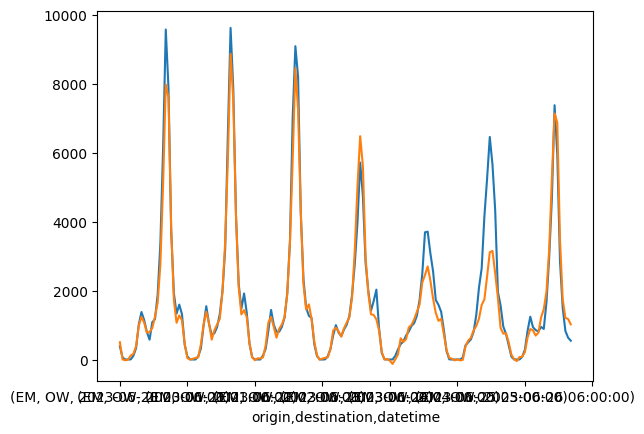

In [9]:
# Show a sample of the data to verify everything was processed correctly
test = results_events.loc['EM', 'OW', datetime(2023, 6, 20):]
test = test[(test.model == 'stgnn') & (test.seed == 13)]
test.passengers.plot()
test.step_01.plot()